In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleaning import get_clean_bikes_dataframe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
INPUT_LENGTH = int(1*12) # 1 hours * 12 stamps per hour

# Functions

In [60]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [61]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int):
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    n_timesteps = df.shape[0]
    n_folds = int((n_timesteps-fold_length)/fold_stride) + 1
    print(f'There are {n_folds} folds.')
    for i in range(n_folds):
        folds.append(df.iloc[i*fold_stride:i*(fold_stride)+fold_length])
    return folds


In [62]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) :
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    print(f'The train split contains {round(train_test_ratio*len(fold))} observations and the test split {round((1-train_test_ratio)*len(fold))} observations.')
    fold_train = fold.iloc[0 : round(train_test_ratio * len(fold))]
    fold_test = fold.iloc[round(train_test_ratio*len(fold))-input_length:]
    return (fold_train,fold_test)

In [63]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]  
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length]
    
    return (X_i, y_i)

In [64]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    X = []
    y=[]
    for i in range(number_of_sequences):
        (X_i,y_i)= get_Xi_yi(bikes_fold_test, input_length,output_length)
        X.append(X_i)
        y.append(y_i)
    return(np.array(X),np.array(y))

In [65]:
class MinMaxNormalization():
    '''MinMax Normalization --> [0, 1]
       x = (x - min) / (max - min).
    '''
    def __init__(self):
        pass
    def fit(self, X):
        maxs = []
        for i in range (X.shape[2]):
            x_v = X[:,:,i]
            maxs.append(x_v.max())
        self._maxs = maxs
        # print("min:", self._min, "max:", self._max)
    def transform(self, X):
        for i in range (X.shape[2]):
            if not self._maxs[i] ==0:
                X[:,:,i] = X[:,:,i] / self._maxs[i]
        return X
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, X):
        # X = (X + 1.) / 2.
        for i in range (X.shape[2]):
            X[:,:,i] = X[:,:,i] * self._maxs[i]
        return X


# Data Loading

In [66]:
bikes_df = pd.read_csv('bikes_df.csv').drop(columns='Unnamed: 0')

# stands_df = get_clean_stands_dataframe()

In [67]:
step = 5
step_str = f'{step}min'

bikes_df=bikes_df.sort_values(by="time")
bikes_df['time']=pd.to_datetime(bikes_df['time'])
bikes_df = bikes_df.resample(step_str, on='time').mean()


# Folding

In [68]:
FOLD_LENGTH = bikes_df.shape[0] # int(24 * 12 * 61) # 24 hours per day, 12 stamps per hour, 61 days
    
FOLD_STRIDE = 1 #int(24 * 12 * 7) # 1 week

TRAIN_TEST_RATIO = 0.66

In [69]:
bikes_folds = get_folds(bikes_df, FOLD_LENGTH, FOLD_STRIDE)

There are 1 folds.


In [70]:
FOLD_LENGTH, FOLD_STRIDE, INPUT_LENGTH

(43718, 1, 12)

In [71]:
bikes_fold = bikes_folds[0]

In [72]:
(bikes_fold_train, bikes_fold_test) = train_test_split(bikes_fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

The train split contains 28854 observations and the test split 14864 observations.


In [73]:
OUTPUT_LENGTH = INPUT_LENGTH
SEQUENCE_STRIDE = 1

In [74]:
# Pour passer en v Station = Sequence

"""

X_train = np.array(pd.DataFrame(X_train_bikes[0]).transpose())
X_test = np.array(pd.DataFrame(X_test_bikes[0]).transpose())
y_train = np.array(pd.DataFrame(y_train_bikes[0]).transpose())
y_test = np.array(pd.DataFrame(y_test_bikes[0]).transpose())

X_train = X_train.reshape((430,INPUT_LENGTH,1))
X_test = X_test.reshape((430,INPUT_LENGTH,1))
y_train = y_train.reshape((430,OUTPUT_LENGTH))
y_test = y_test.reshape((430,OUTPUT_LENGTH))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

"""

'\n\nX_train = np.array(pd.DataFrame(X_train_bikes[0]).transpose())\nX_test = np.array(pd.DataFrame(X_test_bikes[0]).transpose())\ny_train = np.array(pd.DataFrame(y_train_bikes[0]).transpose())\ny_test = np.array(pd.DataFrame(y_test_bikes[0]).transpose())\n\nX_train = X_train.reshape((430,INPUT_LENGTH,1))\nX_test = X_test.reshape((430,INPUT_LENGTH,1))\ny_train = y_train.reshape((430,OUTPUT_LENGTH))\ny_test = y_test.reshape((430,OUTPUT_LENGTH))\n\nprint(X_train.shape, y_train.shape, X_test.shape, y_test.shape) \n\n'

# Train/Test split


In [75]:
N_TRAIN = 20000 # number_of_sequences_train
N_TEST =  5000 # number_of_sequences_test

In [76]:
X_train_bikes, y_train_bikes = get_X_y(bikes_fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_bikes, y_test_bikes = get_X_y(bikes_fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

X_train_bikes.shape, y_train_bikes.shape, X_test_bikes.shape, y_test_bikes.shape

((20000, 12, 430), (20000, 12, 430), (5000, 12, 430), (5000, 12, 430))

# Baseline Model 

In [77]:
y_base_bikes = []
for i in range(y_test_bikes.shape[0]):
    y_base_bikes.append([X_test_bikes[i,-1:,:]]*y_test_bikes.shape[1])

y_base_bikes = np.array(y_base_bikes).reshape((y_test_bikes.shape[0],y_test_bikes.shape[1],y_test_bikes.shape[2]))
y_base_bikes.shape

(5000, 12, 430)

In [78]:
mae = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
mae

0.9336

[0.25, 0.43, 0.58, 0.71, 0.82, 0.93, 1.03, 1.12, 1.21, 1.3, 1.38, 1.45]


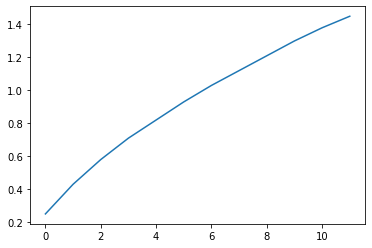

In [79]:
maes = []

for i in range(y_base_bikes.shape[1]):
    maes.append(np.round(np.abs(y_test_bikes[:,i,:]-y_base_bikes[:,i,:]).mean(),2))

print(maes)
plt.plot(maes);

# Modelling

In [80]:
scaler = MinMaxNormalization()
scaler.fit_transform(X_train_bikes)
scaler.transform(y_train_bikes)
scaler.transform(X_test_bikes)
scaler.transform(y_test_bikes)
print(f"X_train : Shape {X_train_bikes.shape}, min {X_train_bikes.min()}, max {X_train_bikes.max()}")
print(f"y_train : Shape {y_train_bikes.shape}, min {y_train_bikes.min()}, max {y_train_bikes.max()}")
print(f"X_test : Shape {X_test_bikes.shape}, min {X_test_bikes.min()}, max {X_test_bikes.max()}")
print(f"y_test : Shape {y_test_bikes.shape}, min {y_test_bikes.min()}, max {y_test_bikes.max()}")

X_train : Shape (20000, 12, 430), min 0.0, max 1.0
y_train : Shape (20000, 12, 430), min 0.0, max 1.0416666666666667
X_test : Shape (5000, 12, 430), min 0.0, max 1.0
y_test : Shape (5000, 12, 430), min 0.0, max 1.0416666666666667


In [81]:
scaler.transform(y_base_bikes)
scaled_base_mae = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
scaled_base_mae


0.0458

In [82]:
stop

NameError: ignored

In [ ]:

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential



def init_model(X_train, y_train):

    model = Sequential([
        layers.GRU(units=512, input_shape = (X_train.shape[1],X_train.shape[2]), activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        layers.GRU(units=512, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        #layers.Dense(64,activation = 'relu'),
        layers.Dense(y_train.shape[2], activation='linear')  
    ])
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss = 'mse', optimizer = adam, metrics = ['mae'])
    
    return model

In [ ]:
model = init_model(X_train_bikes, y_train_bikes)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model,X,y):
    es = EarlyStopping(patience=50,restore_best_weights = True)
    history = model.fit(X,y,epochs = 2000,callbacks=es,batch_size=32, validation_split=0.3)
    return(model,history)

In [ ]:
model = init_model(X_train_bikes,y_train_bikes)
model,history = fit_model(model,X_train_bikes,y_train_bikes)

In [ ]:
res =model.evaluate(X_test_bikes,y_test_bikes)

In [ ]:
y_pred = model.predict(X_test_bikes)

In [ ]:
scaler.inverse_transform(y_test_bikes)
scaler.inverse_transform(y_pred)        

model_mae = round(np.abs(y_test_bikes-y_pred).mean(),4)
model_maes = []

for i in range(y_pred.shape[1]):
    model_maes.append(np.round(np.abs(y_test_bikes[:,i,:]-y_pred_bikes[:,i,:]).mean(),2))

print(model_mae)
print(model_maes)
plt.plot(model_maes, color='orange');
plt.plot(maes);

In [ ]:
y_pred.shape

In [ ]:
plot_history(history)